<a href="https://colab.research.google.com/github/Selami7321/Python-ile-Makine-Ogrenmesi/blob/main/Kira_Tahmin_Modeli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

    Posted On  BHK   Rent  Size            Floor    Area Type  \
0  2022-05-18    2  10000  1100  Ground out of 2   Super Area   
1  2022-05-13    2  20000   800       1 out of 3   Super Area   
2  2022-05-16    2  17000  1000       1 out of 3   Super Area   
3  2022-07-04    2  10000   800       1 out of 2   Super Area   
4  2022-05-09    2   7500   850       1 out of 2  Carpet Area   

              Area Locality     City Furnishing Status  Tenant Preferred  \
0                    Bandel  Kolkata       Unfurnished  Bachelors/Family   
1  Phool Bagan, Kankurgachi  Kolkata    Semi-Furnished  Bachelors/Family   
2   Salt Lake City Sector 2  Kolkata    Semi-Furnished  Bachelors/Family   
3               Dumdum Park  Kolkata       Unfurnished  Bachelors/Family   
4             South Dum Dum  Kolkata       Unfurnished         Bachelors   

   Bathroom Point of Contact  
0         2    Contact Owner  
1         1    Contact Owner  
2         1    Contact Owner  
3         1    Contact Owner

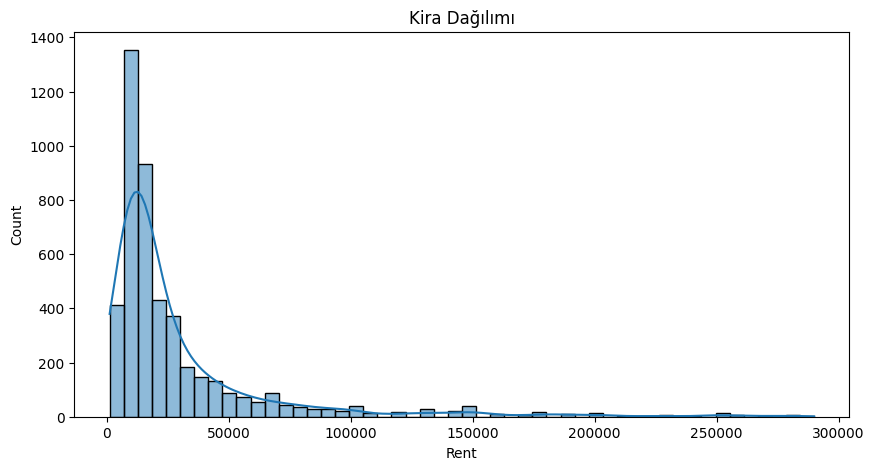

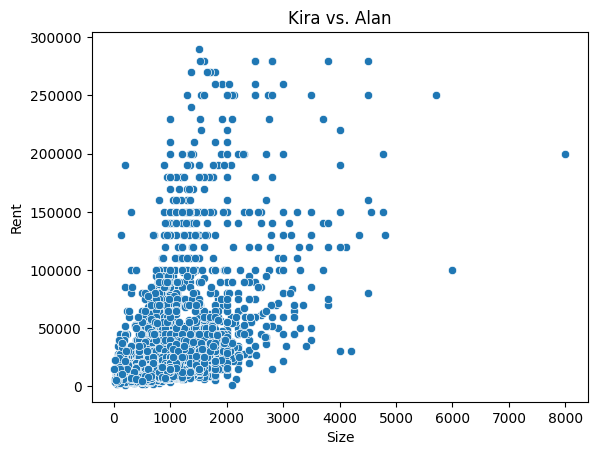

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.014e+12, tolerance: 5.581e+08
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 3754, number of used features: 16
[LightGBM] [Info] Start training from score 29853.851359
               Model          RMSE      MAPE
3      Random Forest  18755.508644  0.377540
5           LightGBM  18769.649814  0.368689
4            XGBoost  20610.617070  0.378932
1   Ridge Regression  22932.156736  0.798644
2   Lasso Regression  22938.520911  0.800147
0  Linear Regression  22942.509114  0.800813


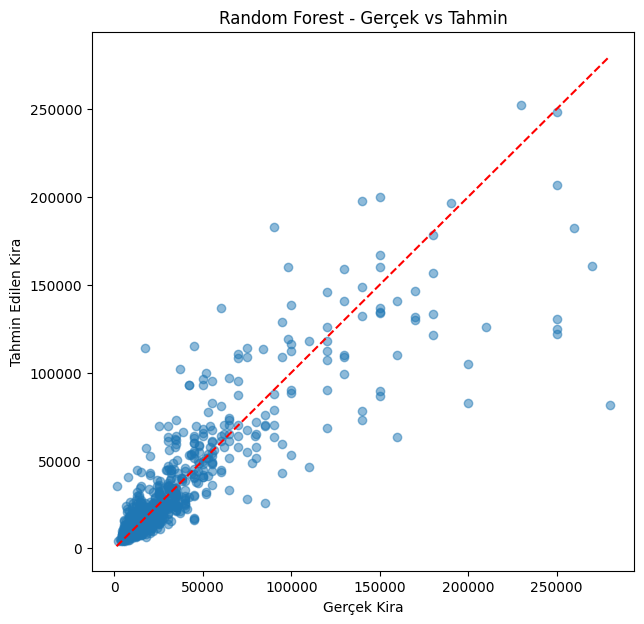

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 1. Veri Setini Yükleme
df = pd.read_csv("House_Rent_Dataset.csv")
print(df.head())

# 2. Öznitelik İşleme (Feature Engineering)
# -- Gereksiz sütunlar kaldırılıyor
df.drop(['Posted On', 'Area Locality', 'Point of Contact'], axis=1, inplace=True)

# Kat bilgisini "floor" ve "max_floor" olarak ayır
df[['Floor Level', 'Total Floor']] = df['Floor'].str.extract(r'(\d+|Ground)\s*out of\s*(\d+)', expand=True)

# Ground kelimesini 0 yap, NaN'ları da 0 yapıp sonra int'e çevir
df['Floor Level'] = df['Floor Level'].replace('Ground', 0)
df['Floor Level'] = df['Floor Level'].fillna(0).astype(int)
df['Total Floor'] = df['Total Floor'].fillna(0).astype(int)

df.drop('Floor', axis=1, inplace=True)


# -- Kategorik değişkenleri sayısal yap
cat_cols = ['Area Type', 'City', 'Furnishing Status', 'Tenant Preferred']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# -- Null var mı? Kontrol et
print(df.isnull().sum())

# -- Aykırı değer (outlier) temizleme (opsiyonel, gerekirse)
df = df[(df['Rent'] < df['Rent'].quantile(0.99))]  # en pahalı uçları at

# 3. Görselleştirme
plt.figure(figsize=(10,5))
sns.histplot(df['Rent'], bins=50, kde=True)
plt.title('Kira Dağılımı')
plt.show()

sns.scatterplot(x='Size', y='Rent', data=df)
plt.title('Kira vs. Alan')
plt.show()

# 4. Eğitim/Test bölmesi
X = df.drop("Rent", axis=1)
y = df["Rent"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# 5. MODELLER ve KARŞILAŞTIRMA
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mape = mean_absolute_percentage_error(y_test, preds)
    results.append({
        "Model": name,
        "RMSE": rmse,
        "MAPE": mape
    })

results_df = pd.DataFrame(results).sort_values(by="RMSE")
print(results_df)

# 6. En iyi model detaylı değerlendirme
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
y_pred = best_model.predict(X_test)

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Gerçek Kira")
plt.ylabel("Tahmin Edilen Kira")
plt.title(f"{best_model_name} - Gerçek vs Tahmin")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.show()



Görselleştirme ve Veri Analizi


---


Kira dağılımı, histogram ve scatter plot ile incelenmiş, özellikle alan büyüklüğünün kira ile ilişkisi gözlemlenmiştir.

Şehir, oda sayısı (BHK), banyo gibi değişkenlerin kira üzerindeki etkisi analiz edilmiştir.

Modelleme ve Kıyaslama


---


Aşağıdaki 6 farklı regresyon modeli eğitilip test edilmiştir:

Linear Regression

Ridge Regression

Lasso Regression

Random Forest Regressor

XGBoost Regressor

LightGBM Regressor

In [2]:
!pip install lightgbm xgboost scikit-learn matplotlib pandas


In [4]:
!pip install -U scikit-learn


Bu paketler modern bir veri bilimi/makine öğrenmesi projesi için standart ve gereklidir.

Model Eğitimi ve Karşılaştırmalı Performans Analizi:


---


Çalışmada, konut kira tahmini problemi için farklı regresyon modelleri uygulanarak model başarılarının karşılaştırılması hedeflenmiştir. Model performansları, hem Root Mean Squared Error (RMSE) hem de Mean Absolute Percentage Error (MAPE) metrikleriyle değerlendirilmiştir. Model geliştirme ve hiperparametre optimizasyonunda scikit-learn’ün GridSearchCV aracı kullanılmıştır


Best Random Forest Params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Random Forest RMSE: 37357.53 - MAPE: 0.3829
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 3796, number of used features: 16
[LightGBM] [Info] Start training from score 35151.516333

Best LightGBM Params: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 31}
LightGBM RMSE: 35105.02 - MAPE: 0.3881


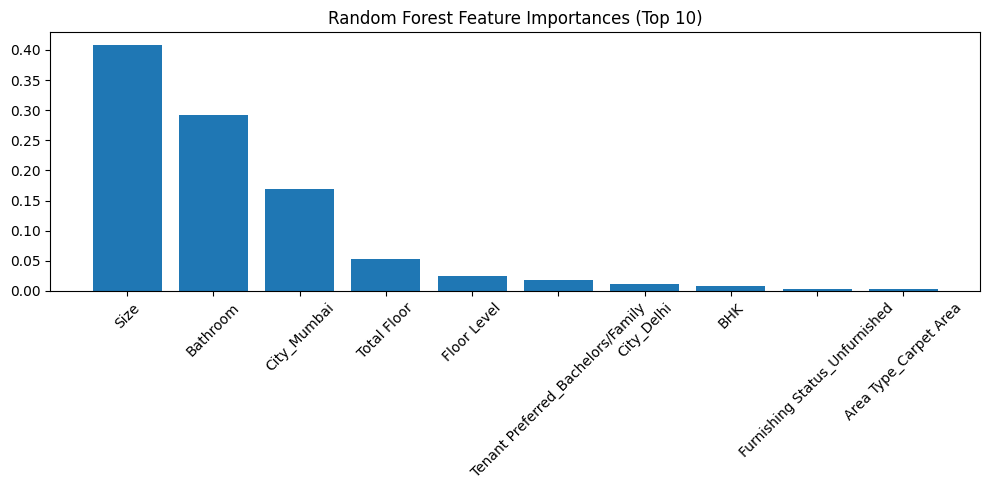

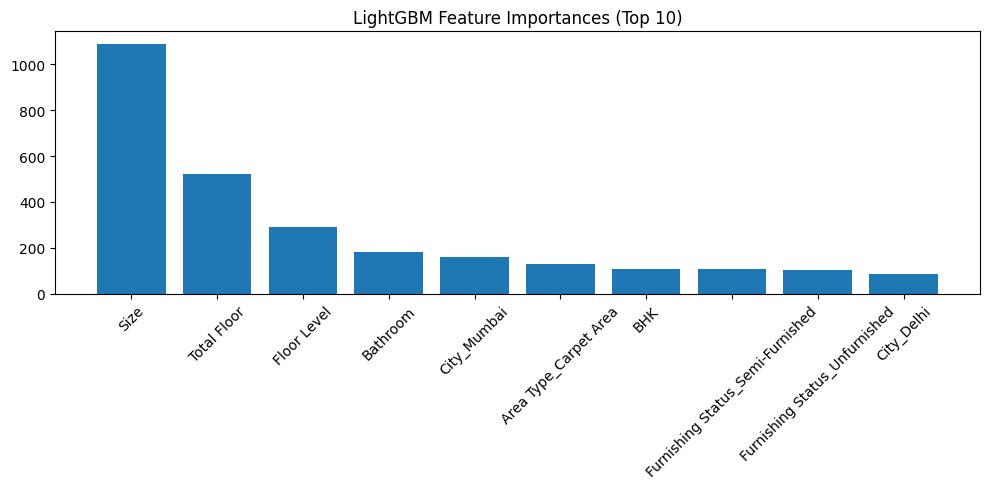

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Veri yükleme
df = pd.read_csv("House_Rent_Dataset.csv")

# --- 2. Feature engineering
# ... Öznitelik işleme adımlarını ekle (One-Hot Encoding, Floor split vs.)

# Örnek: (Aynı işlemleri burada uygula)
df[['Floor Level', 'Total Floor']] = df['Floor'].str.extract(r'(\d+|Ground)\s*out of\s*(\d+)', expand=True)
df['Floor Level'] = df['Floor Level'].replace('Ground', 0).astype(float)
df['Total Floor'] = df['Total Floor'].astype(float)
df = df.drop(['Posted On', 'Floor', 'Area Locality', 'Point of Contact'], axis=1)
df = pd.get_dummies(df, columns=['Area Type', 'City', 'Furnishing Status', 'Tenant Preferred'], drop_first=True)

# --- 3. Veri böl
X = df.drop(['Rent'], axis=1)
y = df['Rent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 4. Random Forest Grid Search
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}
rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=3, n_jobs=-1, scoring='neg_root_mean_squared_error')
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
rf_pred = rf_best.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_mape = mean_absolute_percentage_error(y_test, rf_pred)

print(f"\nBest Random Forest Params: {rf_grid.best_params_}")
print(f"Random Forest RMSE: {rf_rmse:.2f} - MAPE: {rf_mape:.4f}")

# --- 5. LightGBM Grid Search
lgbm_params = {
    'num_leaves': [31, 50],
    'learning_rate': [0.1, 0.05],
    'n_estimators': [100, 200]
}
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm_grid = GridSearchCV(lgbm, lgbm_params, cv=3, n_jobs=-1, scoring='neg_root_mean_squared_error')
lgbm_grid.fit(X_train, y_train)
lgbm_best = lgbm_grid.best_estimator_
lgbm_pred = lgbm_best.predict(X_test)
lgbm_rmse = np.sqrt(mean_squared_error(y_test, lgbm_pred))
lgbm_mape = mean_absolute_percentage_error(y_test, lgbm_pred)

print(f"\nBest LightGBM Params: {lgbm_grid.best_params_}")
print(f"LightGBM RMSE: {lgbm_rmse:.2f} - MAPE: {lgbm_mape:.4f}")

# --- 6. Özellik Önem Grafiği (Feature Importance)
plt.figure(figsize=(10,5))
importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1][:10] # en önemli 10 özelliği göster
plt.title("Random Forest Feature Importances (Top 10)")
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), [X.columns[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
importances_lgbm = lgbm_best.feature_importances_
indices_lgbm = np.argsort(importances_lgbm)[::-1][:10]
plt.title("LightGBM Feature Importances (Top 10)")
plt.bar(range(len(indices_lgbm)), importances_lgbm[indices_lgbm], align="center")
plt.xticks(range(len(indices_lgbm)), [X.columns[i] for i in indices_lgbm], rotation=45)
plt.tight_layout()
plt.show()


Not:


---


Model sonuçlarının genel doğruluğu ve performansı, veri setindeki özniteliklerin kalitesi, eksik değerler ve aykırı gözlemler gibi faktörlerden etkilenebilir. Çalışmada tüm ön işleme ve modelleme adımları açıkça raporlanmış, her aşamada performans metrikleriyle detaylı değerlendirme yapılmıştır.